# Data Analysis
#### KF 01/03/2019

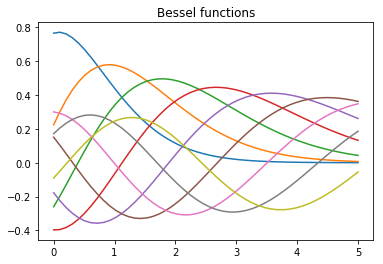

In [1]:
# 绘图案例 an example of matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn
from IPython.display import display, clear_output
import time
x = np.linspace(0,5)
f, ax = plt.subplots()
ax.set_title("Bessel functions")

for n in range(1,10):
    time.sleep(1)
    ax.plot(x, jn(x,n))
    clear_output(wait=True)
    display(f)

# close the figure at the end, so we don't get a duplicate
# of the last plot
plt.close()

In [3]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [4]:
data_dir = 'dataset'
#submit_data = pd.read_csv(os.path.join(data_dir, 'jinnan_round1_submit_20181227.csv'), encoding = 'gb18030')
test = pd.read_csv(os.path.join(data_dir, 'jinnan_round1_testA_20181227.csv'), encoding = 'gb18030')
train = pd.read_csv(os.path.join(data_dir, 'jinnan_round1_train_20181227.csv'), encoding = 'gb18030')

In [5]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [6]:
# 删除缺失率超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

In [7]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [8]:
# 日期中有些输入错误和遗漏
def t2s(t):
    try:
        h,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600
        elif t=='1900/1/1 2:30':
            return 2*3600+30*60
        elif t =='700':
            return 7*3600
        elif t==-1:
            return -1
        else:
            print("t ->", t)
            return 0
    
    try:
        tm = int(h)*3600+int(m)*60+int(s)
    except:
        print("tm ->", t)
        return 30*60
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(t2s)

def getDuration(se):
    try:
        sh,sm,eh,em=re.split("[:,-]",se)
    except:
        if se in ['14::30-15:30', 
                  '13；00-14:00', 
                  '21:00-22；00', 
                  '2:00-3;00', 
                  '15:00-1600', 
                  '12；30-13:30', 
                  '1；00-2:00',
                  '17；00-18:00']:
            return 3600 
        
        elif se in ['0；00-1:30', 
                    '11:30-13；00', 
                    '1:30-3;00', 
                    '20:30-22；00',
                    '3；00-4:30',
                    '13::30-15:00',
                    '5:10-6；30',
                    '18::30-20:00']:
            return 5400
        
        elif se in ['15；00-17:00', 
                    '20；00-22:00', 
                    '22"00-0:00', 
                    '6:00-8；00', 
                    '20:00-22;00',
                    '2:00-4::00',
                    '10；00-12:00']:
            return 7200
        elif se == '16；00-19:30':
            return 12600
        
        elif se==-1:
            return -1
        else:
            print("se ->", se)
            return 30*60
        
    try:
        tm = int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600
    except:
        if se=='19:-20:05':
            return 3600
        else:
            print("se tm ->", se)
            return 30*60
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)



t -> 1900/1/21 0:00
t -> 1900/1/29 0:00
t -> 1900/1/21 0:00
t -> 1900/1/22 0:00
tm -> :30:00
t -> 1900/1/12 0:00
t -> 1900/3/13 0:00
se tm -> 6:00-6:30分
se -> 18:00:-18:30
se -> 18:00:-18:30
se -> 18:00:-18:30
se tm -> 6:00-6:30分
se tm -> 6:00-6:30分
se -> 14；00-14:30


In [9]:
cate_columns = [f for f in data.columns if f != '样本id']

In [10]:
#label encoder
for f in cate_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]

添加新特征，将收率进行分箱，然后构造每个特征中的类别对应不同收率的均值

In [11]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_features = []

In [12]:
train.head(10)

,样本id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,target,intTarget_0.0,intTarget_1.0,intTarget_2.0,intTarget_3.0,intTarget_4.0
0,sample_1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.879,1,0,0,0,0
1,sample_1698,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,1,1,0,0,0,1,1,0,0.902,0,1,0,0,0
2,sample_639,1,1,0,0,1,2,1,1,1,1,1,1,1,0,0,0,1,2,1,1,1,1,0,1,1,2,0,0,0,1,1,0,0.936,0,0,1,0,0
3,sample_483,2,0,0,0,2,0,2,0,2,0,2,0,1,0,0,1,2,3,2,2,1,2,0,2,0,3,0,0,0,0,0,0,0.902,0,1,0,0,0
4,sample_617,3,1,0,0,3,1,3,1,3,1,3,1,1,1,0,0,3,1,3,1,1,1,0,3,1,4,0,0,0,1,1,1,0.983,0,0,0,0,1
5,sample_373,4,2,1,1,4,0,4,1,4,1,4,2,0,0,0,0,4,3,4,3,0,3,1,4,0,5,0,0,0,0,0,1,0.935,0,0,1,0,0
6,sample_577,5,1,0,0,5,1,5,1,5,1,5,1,1,1,0,0,5,1,5,1,1,1,0,5,1,6,0,0,0,1,1,0,0.902,0,1,0,0,0
7,sample_212,6,1,0,0,6,1,6,0,6,0,6,3,1,1,0,0,4,4,6,1,1,1,0,6,1,7,0,0,0,1,1,0,0.891,1,0,0,0,0
8,sample_521,7,3,0,0,7,0,7,2,7,2,7,1,0,0,0,0,6,3,7,2,1,4,2,7,0,8,0,0,0,0,0,1,0.947,0,0,1,0,0
9,sample_1026,8,3,0,0,8,0,8,0,8,0,8,1,1,0,0,0,7,3,8,2,1,5,3,8,2,9,1,0,0,0,0,0,0.902,0,1,0,0,0


In [13]:
for f1 in cate_columns:
    for f2 in li:
        col_name = f1+"_"+f2+'_mean'
        mean_features.append(col_name)
        order_label = train.groupby([f1])[f2].mean()
        for df in [train, test]:
            df[col_name] = df[f].map(order_label)

train.drop(li, axis=1, inplace=True)
train.head(10)

,样本id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,target,A5_intTarget_0.0_mean,A5_intTarget_1.0_mean,A5_intTarget_2.0_mean,A5_intTarget_3.0_mean,A5_intTarget_4.0_mean,A6_intTarget_0.0_mean,A6_intTarget_1.0_mean,A6_intTarget_2.0_mean,A6_intTarget_3.0_mean,A6_intTarget_4.0_mean,A7_intTarget_0.0_mean,A7_intTarget_1.0_mean,A7_intTarget_2.0_mean,A7_intTarget_3.0_mean,A7_intTarget_4.0_mean,A8_intTarget_0.0_mean,A8_intTarget_1.0_mean,A8_intTarget_2.0_mean,A8_intTarget_3.0_mean,A8_intTarget_4.0_mean,A9_intTarget_0.0_mean,A9_intTarget_1.0_mean,A9_intTarget_2.0_mean,A9_intTarget_3.0_mean,A9_intTarget_4.0_mean,A10_intTarget_0.0_mean,A10_intTarget_1.0_mean,A10_intTarget_2.0_mean,A10_intTarget_3.0_mean,A10_intTarget_4.0_mean,A11_intTarget_0.0_mean,A11_intTarget_1.0_mean,A11_intTarget_2.0_mean,A11_intTarget_3.0_mean,A11_intTarget_4.0_mean,A12_intTarget_0.0_mean,A12_intTarget_1.0_mean,A12_intTarget_2.0_mean,A12_intTarget_3.0_mean,A12_intTarget_4.0_mean,A14_intTarget_0.0_mean,A14_intTarget_1.0_mean,A14_intTarget_2.0_mean,A14_intTarget_3.0_mean,A14_intTarget_4.0_mean,A15_intTarget_0.0_mean,A15_intTarget_1.0_mean,A15_intTarget_2.0_mean,A15_intTarget_3.0_mean,A15_intTarget_4.0_mean,A16_intTarget_0.0_mean,A16_intTarget_1.0_mean,A16_intTarget_2.0_mean,A16_intTarget_3.0_mean,A16_intTarget_4.0_mean,A17_intTarget_0.0_mean,A17_intTarget_1.0_mean,A17_intTarget_2.0_mean,A17_intTarget_3.0_mean,A17_intTarget_4.0_mean,A19_intTarget_0.0_mean,A19_intTarget_1.0_mean,A19_intTarget_2.0_mean,A19_intTarget_3.0_mean,A19_intTarget_4.0_mean,A20_intTarget_0.0_mean,A20_intTarget_1.0_mean,A20_intTarget_2.0_mean,A20_intTarget_3.0_mean,A20_intTarget_4.0_mean,A21_intTarget_0.0_mean,A21_intTarget_1.0_mean,A21_intTarget_2.0_mean,A21_intTarget_3.0_mean,A21_intTarget_4.0_mean,A22_intTarget_0.0_mean,A22_intTarget_1.0_mean,A22_intTarget_2.0_mean,A22_intTarget_3.0_mean,A22_intTarget_4.0_mean,A24_intTarget_0.0_mean,A24_intTarget_1.0_mean,A24_intTarget_2.0_mean,A24_intTarget_3.0_mean,A24_intTarget_4.0_mean,A25_intTarget_0.0_mean,A25_intTarget_1.0_mean,A25_intTarget_2.0_mean,A25_intTarget_3.0_mean,A25_intTarget_4.0_mean,A26_intTarget_0.0_mean,A26_intTarget_1.0_mean,A26_intTarget_2.0_mean,A26_intTarget_3.0_mean,A26_intTarget_4.0_mean,A27_intTarget_0.0_mean,A27_intTarget_1.0_mean,A27_intTarget_2.0_mean,A27_intTarget_3.0_mean,A27_intTarget_4.0_mean,A28_intTarget_0.0_mean,A28_intTarget_1.0_mean,A28_intTarget_2.0_mean,A28_intTarget_3.0_mean,A28_intTarget_4.0_mean,B1_intTarget_0.0_mean,B1_intTarget_1.0_mean,B1_intTarget_2.0_mean,B1_intTarget_3.0_mean,B1_intTarget_4.0_mean,B4_intTarget_0.0_mean,B4_intTarget_1.0_mean,B4_intTarget_2.0_mean,B4_intTarget_3.0_mean,B4_intTarget_4.0_mean,B5_intTarget_0.0_mean,B5_intTarget_1.0_mean,B5_intTarget_2.0_mean,B5_intTarget_3.0_mean,B5_intTarget_4.0_mean,B6_intTarget_0.0_mean,B6_intTarget_1.0_mean,B6_intTarget_2.0_mean,B6_intTarget_3.0_mean,B6_intTarget_4.0_mean,B7_intTarget_0.0_mean,B7_intTarget_1.0_mean,B7_intTarget_2.0_mean,B7_intTarget_3.0_mean,B7_intTarget_4.0_mean,B8_intTarget_0.0_mean,B8_intTarget_1.0_mean,B8_intTarget_2.0_mean,B8_intTarget_3.0_mean,B8_intTarget_4.0_mean,B9_intTarget_0.0_mean,B9_intTarget_1.0_mean,B9_intTarget_2.0_mean,B9_intTarget_3.0_mean,B9_intTarget_4.0_mean,B10_intTarget_0.0_mean,B10_intTarget_1.0_mean,B10_intTarget_2.0_mean,B10_intTarget_3.0_mean,B10_intTarget_4.0_mean,B11_intTarget_0.0_mean,B11_intTarget_1.0_mean,B11_intTarget_2.0_mean,B11_intTarget_3.0_mean,B11_intTarget_4.0_mean,B12_intTarget_0.0_mean,B12_intTarget_1.0_mean,B12_intTarget_2.0_mean,B12_intTarget_3.0_mean,B12_intTarget_4.0_mean,B14_intTarget_0.0_mean,B14_intTarget_1.0_mean,B14_intTarget_2.0_mean,B14_intTarget_3.0_mean,B14_intTarget_4.0_mean
0,sample_1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.879,0.285714,0.285714,0.428571,0.000000,0.000000,0.157895,0.210526,0.438596,0.105263,0.070175,0.161526,0.284903,0.396916,0.090097,0.056818,0.161526,0.284903,0.396916,0.090

In [14]:
train.drop(['样本id','target'], axis=1, inplace=True)
test = test[train.columns]
X_train = train.values
y_train = target.values
X_test = test.values

In [15]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000213783	valid_1's l2: 0.000239181
[400]	training's l2: 0.000165183	valid_1's l2: 0.000194563
[600]	training's l2: 0.000148755	valid_1's l2: 0.000186707
[800]	training's l2: 0.000139873	valid_1's l2: 0.000183744
[1000]	training's l2: 0.000134222	valid_1's l2: 0.000182278
[1200]	training's l2: 0.000129908	valid_1's l2: 0.000181501
[1400]	training's l2: 0.000126596	valid_1's l2: 0.00018078
[1600]	training's l2: 0.000124056	valid_1's l2: 0.000180303
[1800]	training's l2: 0.000121917	valid_1's l2: 0.000180149
[2000]	training's l2: 0.000120515	valid_1's l2: 0.000179737
Early stopping, best iteration is:
[1933]	training's l2: 0.000120594	valid_1's l2: 0.000179707
fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000213309	valid_1's l2: 0.000235001
[400]	training's l2: 0.000164166	valid_1's l2: 0.000208251
[600]	training's l2: 0.000147047	valid_1's l2: 0

In [16]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 20, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423819
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.257017	valid_data-rmse:0.257753
[200]	train-rmse:0.156601	valid_data-rmse:0.157266
[300]	train-rmse:0.095965	valid_data-rmse:0.096514
[400]	train-rmse:0.059488	valid_data-rmse:0.060007
[500]	train-rmse:0.037742	valid_data-rmse:0.038452
[600]	train-rmse:0.024958	valid_data-rmse:0.026144
[700]	train-rmse:0.017446	valid_data-rmse:0.019419
[800]	train-rmse:0.013006	valid_data-rmse:0.015998
[900]	train-rmse:0.01037	valid_data-rmse:0.014335
[1000]	train-rmse:0.008831	valid_data-rmse:0.01357
[1100]	train-rmse:0.007894	valid_data-rmse:0.013224
[1200]	train-rmse:0.007332	valid_data-rmse:0.013096
[1300]	train-rmse:0.006983	valid_data-rmse:0.013055
[1400]	train-rmse:0.006758	valid_data-rmse:0.013069
[1500]	train-rmse:0.006615	valid_data-rmse:0.013093
Stopping. Best it

In [17]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00017578020127561166

In [18]:
sub_df = pd.read_csv(os.path.join(data_dir, 'jinnan_round1_submit_20181227.csv'), header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
res_dir = 'results'
sub_df.to_csv(os.path.join(res_dir, "KF-20180103.csv"), index=False, header=None)